# Notebook showing modifications to the supernormalizer to detect more peaks.
This script illustrated how the argument ```return_time_before_last_peak``` in the ```supernormalizer```-function helps detect more peaks.

In [1]:
# imports

# Allow display of images
from IPython.display import display, Image

# Import the required modules
import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd

# Add path
import os
import sys
path = os.path.abspath(os.path.join('..'))
sys.path.append(path)

# Tools from brainsignal library
import brainsignal.datageneration as dg
import brainsignal.datanalysis as da
import brainsignal.preprocessing as pp
import brainsignal.causality as ca
import brainsignal.detectionpeak as dp

# This makes the plots appear inside the notebook
%matplotlib inline

In [2]:
import brainsignal.supernormalizer as sn
%load_ext autoreload
%autoreload 2

In [3]:
# ABP data
file_ABP=glob.glob('../data/PatID 2_Txt Files/WAVE_ABP_*', recursive=True)[0]
data_ABP=pd.read_csv(file_ABP,header=None, decimal=',', delimiter=';')
data_array_ABP=np.array(data_ABP.values)
ABP_signal=data_array_ABP.transpose()[0]

# ICP data
file_IPC = glob.glob('../data/PatID 2_Txt Files/WAVE_ICP*', recursive=True)[0]
data_IPC=pd.read_csv(file_IPC,header=None, decimal=',', delimiter=';')
data_array_IPC=np.array(data_IPC.values)
ICP_signal=data_array_IPC.transpose()[0]

fs=200 #constant
ABP_time=np.arange(len(ABP_signal))/fs

Text(0, 0.5, 'ABP [mmHg]')

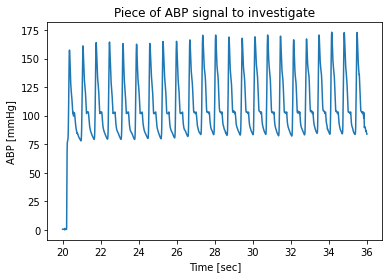

In [4]:
# Choose an interval to work with.
indices_start = 4000 
indices_end = 7200 
indices = np.arange(indices_start, indices_end + 1)
# Defining a new spantime that start at index 4000
spantime = ABP_time[indices]
main_signal = ABP_signal[indices]
plt.plot(spantime, main_signal)
plt.title("Piece of ABP signal to investigate")
plt.xlabel("Time [sec]")
plt.ylabel("ABP [mmHg]")

In [5]:
# Will set up an example with three windows

# Choose a timewindow and slide of 2.7 seconds.
# The value 2.7 was found by trial and error
# so that all peaks can be found when sliding a window.
time_window = 2.7
time_slide = 2.7

# Find the indices for the windows. 
# Also find the indices for all the intervals.
ti_1 = spantime[0]
ti_2 = ti_1 + time_slide
ti_3 = ti_2 + time_slide

indices_1 = da.indexseq(ti_1,time_window, spantime)
indices_2 = da.indexseq(ti_2,time_window, spantime)
indices_3 = da.indexseq(ti_3,time_window, spantime)
indices_all_windows = da.indexseq(ti_1, time_slide*3, spantime)

Text(0, 0.5, 'ABP [mmHg]')

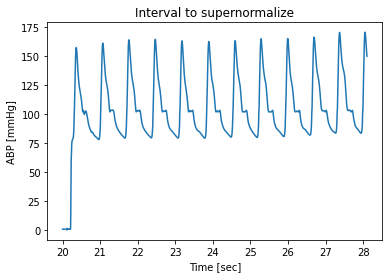

In [6]:
# Plot of the three windows
plt.plot(spantime[indices_all_windows], main_signal[indices_all_windows])
plt.title("Interval to supernormalize")
plt.xlabel("Time [sec]")
plt.ylabel("ABP [mmHg]")

Text(0, 0.5, 'ABP [mmHg]')

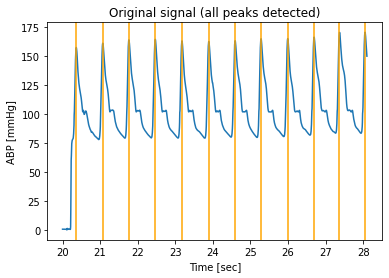

In [7]:
# Estimating the wave-length
peak_signal, _ = da.searchpeak(main_signal[indices_all_windows], spantime[indices_all_windows], fmin=0.5, fmax=2)
# Estimate the number of points in a wavelength.
peak_guess = 1/peak_signal*fs 
# Search for the indices of the peaks.
# The peak_guess is scaled by scale_factor.
scale_factor = 0.8
peaks = dp.peakdetection4(main_signal[indices_all_windows], peak_guess*scale_factor)[0]

# checking if all peaks are found
plt.plot(spantime[indices_all_windows], main_signal[indices_all_windows])
for p in spantime[indices_all_windows][peaks]:
    plt.axvline(x=p, color='orange')
plt.title("Original signal (all peaks detected)")
plt.xlabel("Time [sec]")
plt.ylabel("ABP [mmHg]")

In [8]:
# We shift the signals so we can see our supernormalizer
# method works at the endpoitns of the intervals
shifted_main_signal = np.copy(main_signal)
shifted_main_signal[indices_2[:-1]] += 10
shifted_main_signal[indices_3[:-1]] += 20

Text(0, 0.5, 'ABP [mmHg]')

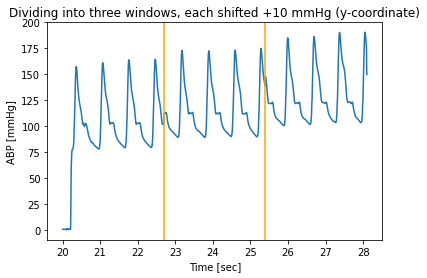

In [9]:
# Plot the modified signal
plt.plot(spantime[indices_all_windows], shifted_main_signal[indices_all_windows])
for p in [spantime[indices_2[0]], spantime[indices_3[0]]]:
    plt.axvline(x=p, color='orange')
plt.title("Dividing into three windows, each shifted +10 mmHg (y-coordinate)")
plt.xlabel("Time [sec]")
plt.ylabel("ABP [mmHg]")

Text(0, 0.5, 'ABP [mmHg]')

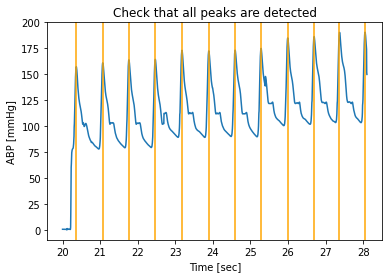

In [10]:
# Checking that all peaks are found
peak_signal2, _ = da.searchpeak(shifted_main_signal[indices_all_windows], spantime[indices_all_windows], fmin=0.5, fmax=2)
# Estimate the number of points in a wavelength.
peak_guess2 = 1/peak_signal2*fs 
# Search for the indices of the peaks.
# The peak_guess is scaled by scale_factor.
scale_factor = 0.8
peaks2 = dp.peakdetection4(shifted_main_signal[indices_all_windows], peak_guess2*scale_factor)[0]

plt.plot(spantime[indices_all_windows], shifted_main_signal[indices_all_windows])
for p in spantime[indices_all_windows][peaks2]:
    plt.axvline(x=p, color='orange')
plt.title("Check that all peaks are detected")
plt.xlabel("Time [sec]")
plt.ylabel("ABP [mmHg]")

In [11]:
# First of three intervals
ti = spantime[0]
idx = da.indexseq(ti, time_window, spantime)
data_matrix, time_before_last_peak = sn.supernormalizer(spantime[idx], shifted_main_signal[idx], nt=150, return_time_before_last_peak=True)

# There is no padding for the first window, so we make a call
# to the supernormalizer with return_time_before_last_peak set to True.
normalized_time = data_matrix[:,0]
normalized_time_padded = data_matrix[:,0] 
virtual_time = data_matrix[:,1]
virtual_time_padded = data_matrix[:,1]
supernormalized_signal = data_matrix[:,2]
supernormalized_signal_padded = data_matrix[:,2]

# Two last intervals
for i in range(2):
    ti = ti + time_slide
    # No padding
    idx = da.indexseq(ti, time_window, spantime)
    data_matrix = sn.supernormalizer(spantime[idx], shifted_main_signal[idx], nt=150)
    normalized_time = np.concatenate((normalized_time, data_matrix[:,0]))
    virtual_time = np.concatenate((virtual_time, (data_matrix[:,1]+virtual_time[-1])))
    supernormalized_signal = np.concatenate((supernormalized_signal, data_matrix[:,2]))

    # Padding
    idx_padded = da.indexseq(time_before_last_peak, (ti-time_before_last_peak) + time_slide, spantime)
    data_matrix_padded, time_before_last_peak = sn.supernormalizer(spantime[idx_padded], shifted_main_signal[idx_padded], nt=150, return_time_before_last_peak=True)
    normalized_time_padded = np.concatenate((normalized_time_padded, data_matrix_padded[:,0]))
    virtual_time_padded = np.concatenate((virtual_time_padded, (data_matrix_padded[:,1]+virtual_time_padded[-1])))
    supernormalized_signal_padded = np.concatenate((supernormalized_signal_padded, data_matrix_padded[:,2]))

Text(0, 0.5, 'ABP [mmHg]')

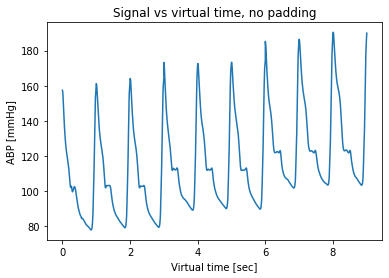

In [12]:
plt.plot(virtual_time, supernormalized_signal)
plt.title("Signal vs virtual time, no padding")
plt.xlabel("Virtual time [sec]")
plt.ylabel("ABP [mmHg]")

Text(0, 0.5, 'ABP [mmHg]')

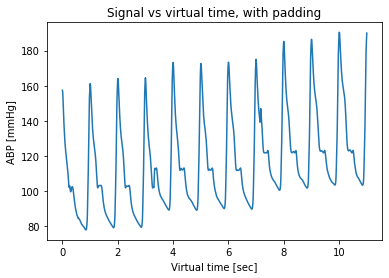

In [13]:
plt.plot(virtual_time_padded, supernormalized_signal_padded)
plt.title("Signal vs virtual time, with padding")
plt.xlabel("Virtual time [sec]")
plt.ylabel("ABP [mmHg]")

Text(0, 0.5, 'ABP [mmHg]')

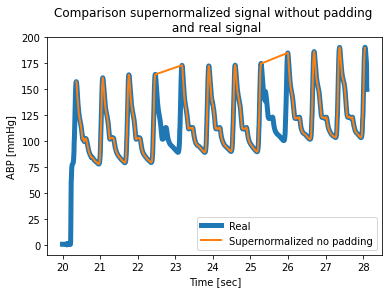

In [14]:
plt.plot(spantime[indices_all_windows], shifted_main_signal[indices_all_windows], linewidth=5)
plt.plot(normalized_time, supernormalized_signal, linewidth=2)
plt.legend(['Real', 'Supernormalized no padding'])
plt.title("Comparison supernormalized signal without padding \n and real signal")
plt.xlabel("Time [sec]")
plt.ylabel("ABP [mmHg]")

Text(0, 0.5, 'ABP [mmHg]')

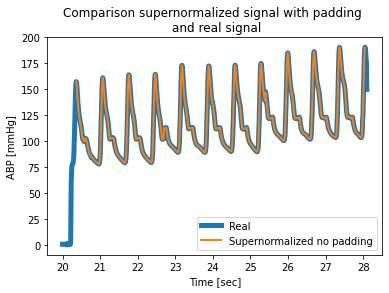

In [15]:
plt.plot(spantime[indices_all_windows], shifted_main_signal[indices_all_windows], linewidth=5)
plt.plot(normalized_time_padded, supernormalized_signal_padded, linewidth=2)
plt.legend(['Real', 'Supernormalized no padding'])
plt.title("Comparison supernormalized signal with padding \n and real signal")
plt.xlabel("Time [sec]")
plt.ylabel("ABP [mmHg]")

Text(0, 0.5, 'ABP [mmHg]')

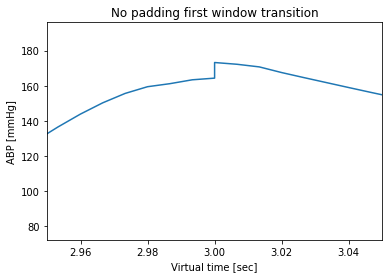

In [16]:
plt.plot(virtual_time, supernormalized_signal)
plt.title("No padding first window transition")
plt.xlim([2.95, 3.05])
plt.xlabel("Virtual time [sec]")
plt.ylabel("ABP [mmHg]")

(5.95, 6.05)

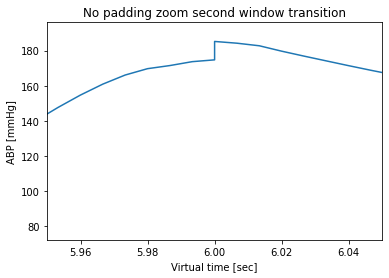

In [17]:
plt.plot(virtual_time, supernormalized_signal)
plt.title("No padding zoom second window transition")
plt.xlabel("Virtual time [sec]")
plt.ylabel("ABP [mmHg]")
plt.xlim([5.95, 6.05])

Text(0, 0.5, 'ABP [mmHg]')

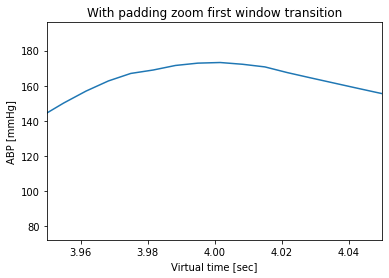

In [18]:
plt.plot(virtual_time_padded, supernormalized_signal_padded)
plt.title("With padding zoom first window transition")
plt.xlim([3.95, 4.05])
plt.xlabel("Virtual time [sec]")
plt.ylabel("ABP [mmHg]")

Text(0, 0.5, 'ABP [mmHg]')

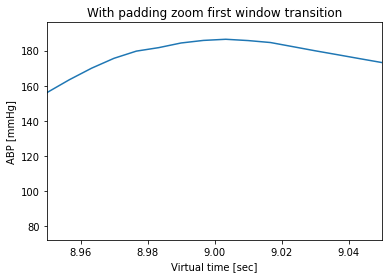

In [19]:
plt.plot(virtual_time_padded, supernormalized_signal_padded)
plt.title("With padding zoom first window transition")
plt.xlim([8.95, 9.05])
plt.xlabel("Virtual time [sec]")
plt.ylabel("ABP [mmHg]")